<a href="https://colab.research.google.com/github/aiyufan3/AIPI-XAI-Explainable-AI/blob/main/AIPI_Assignment_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Explainable AI
### Description
The project focuses on generating local explanations for predictions made by a pre-trained black-box image classification model (ResNet34) using the LIME (Local Interpretable Model-agnostic Explanations) method. The notebook provides insights into how specific regions of an image contribute to the model's decision-making process. The explanations are visualized using a variety of visualization techniques to illustrate the positive and negative contributions of each image segment.

### Yufan Ai


# Environment Setting up


*   Install the required libraries, such as torch, torchvision, shap, lime, and
matplotlib.

*   Import necessary modules and packages for model building, data handling, and visualization.

*   Configure the device to run on GPU or CPU, depending on availability.

In [1]:
# Install necessary libraries (if not already installed)
!pip install shap lime torch torchvision matplotlib

# Import standard libraries
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# For pre-trained ResNet and image processing
from torchvision import models, transforms
from PIL import Image

# For LIME explanation
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Remove Colab default sample_data
!rm -r ./sample_data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 11.0 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a89c0d76c63d827f9496d338dc1e868e713bb672ad7de36ea0f66a09c6fc5b1a
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
Using device: cpu


# Loading and Preprocessing Data

*   A pre-trained ResNet34 model is loaded to serve as the black-box model for the explanations.
*   A sample image is used for testing the LIME explanations.



--2024-10-03 08:00:38--  https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 661378 (646K) [image/jpeg]
Saving to: ‘sample_image.jpg’

sample_image.jpg    100%[===================>] 645.88K  --.-KB/s    in 0.02s   

2024-10-03 08:00:38 (31.4 MB/s) - ‘sample_image.jpg’ saved [661378/661378]



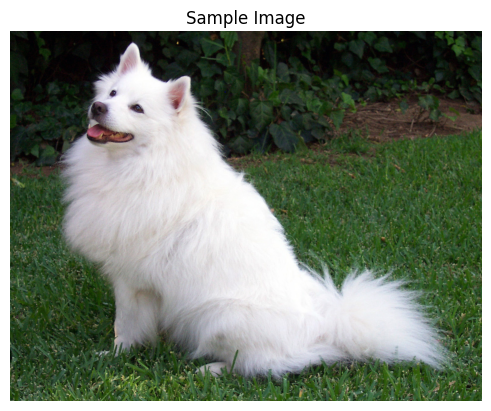

In [4]:
# Load the pre-trained ResNet34 model
model = models.resnet34(pretrained=True)
model = model.to(device)

model.eval()  # Set the model to evaluation mode

# Define transformation for input image (resize, normalize)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Download a sample image (or use your own)
!wget https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg -O sample_image.jpg


# Load the image and preprocess
img = Image.open("sample_image.jpg")
img_tensor = preprocess(img).unsqueeze(0).to(device)

# Display the image
plt.imshow(img)
plt.title("Sample Image")
plt.axis("off")
plt.show()


Feed the preprocessed image into the ResNet34 model to obtain a prediction.

In [5]:
# Get the model's prediction for the image
output = model(img_tensor)
_, predicted_class = torch.max(output, 1)
predicted_class = predicted_class.cpu().numpy()[0]
print(f"Predicted Class: {predicted_class}")

Predicted Class: 258


# Model Selection

### LIME Explanation for Image Classification
LIME is an acronym for Local Interpretable Model-agnostic Explanations, which is availed to elucidate the classification decisions made by a pre-trained ResNet34 model for an image. However, LIME doesn't make an attempt to provide explanations like SHAP. It rather tries to give local explanations. It highlights which part of the image contributed most to any model's prediction in consideration. The perturbations occur by hiding or altering some region of the input image and measuring the change in predictions made by the model.

  0%|          | 0/9 [00:00<?, ?it/s]

Top labels identified by LIME: [270]


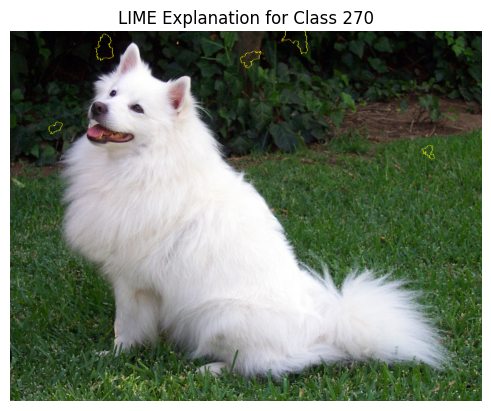

In [9]:
# Generate explanation for the image
explanation = explainer.explain_instance(np.array(img), predict, top_labels=1, hide_color=0, num_samples=9)

# Display the top label found by LIME
top_labels = explanation.top_labels
print(f"Top labels identified by LIME: {top_labels}")

# Use the label that LIME considers as the top label for this explanation
lime_label = top_labels[0]  # Select the first top label identified by LIME

# Get image and mask for the top label
temp, mask = explanation.get_image_and_mask(lime_label, positive_only=True, num_features=5, hide_rest=False)

# Display the LIME explanation
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"LIME Explanation for Class {lime_label}")
plt.axis("off")
plt.show()


This visualization shows the LIME explanation for the initial top class prediction by the model, Class 270, which is unclassifed with the predicted Class 258. The regions indicate that certain parts of the image, like the background, may have contributed to the classification, suggesting potential confusion in the model’s understanding.

### Generating LIME Explanations Based on Predicted Labels
This procedure involves configuring the LIME explanation to focus on the class predicted by the model as the highest probability class, rather than the top label identified by LIME. The code is adjusted to directly target the predicted class (258), ensuring that the explanation aligns accurately with the model’s output. A comprehensive explanation setup is then included to enhance clarity and provide deeper insights into the model’s decision-making process.

  0%|          | 0/10 [00:00<?, ?it/s]

Predicted Class by Model: 258


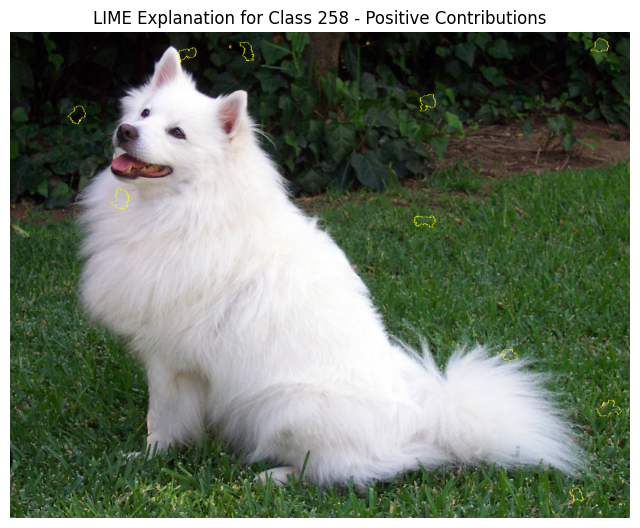

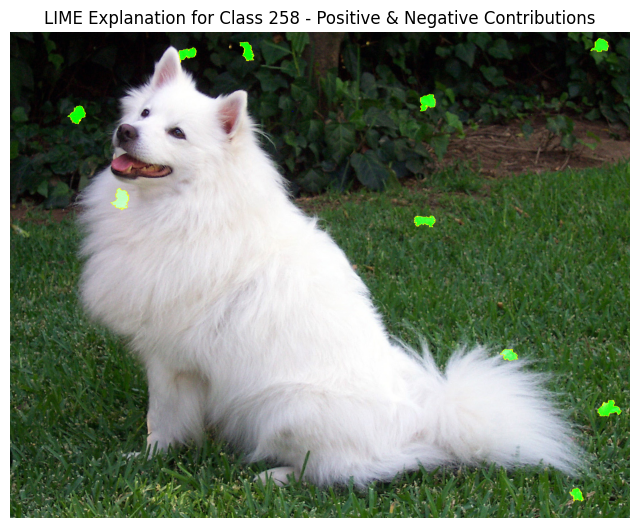

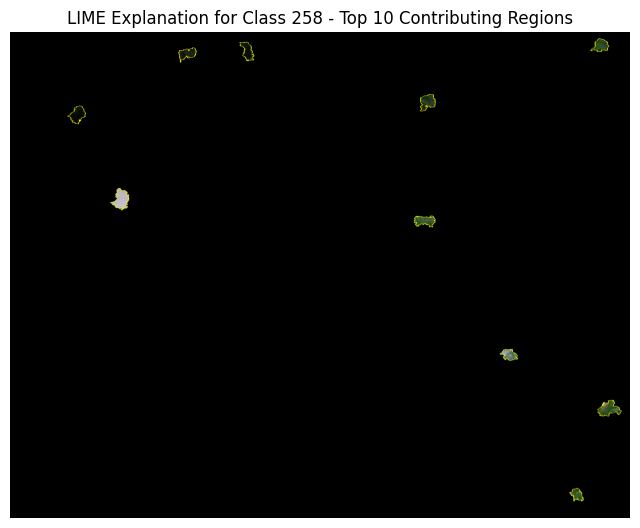

In [19]:
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Define the predict function that LIME will use for generating explanations
def predict(image_array):
    # Convert each image in the batch to a PyTorch tensor and preprocess
    batch = torch.stack([preprocess(Image.fromarray(img)) for img in image_array], dim=0)
    batch = batch.to('cpu')  # Ensure the tensor is on the same device (CPU)
    output = model(batch)
    return output.detach().cpu().numpy()

# Create a LIME image explainer
explainer = lime.lime_image.LimeImageExplainer()

# Convert the image to a numpy array
img_np = np.array(img)

# Use the predicted class for the LIME explanation
explanation = explainer.explain_instance(
    img_np,
    predict,
    labels=[predicted_class],
    hide_color=0,
    num_samples=100
)

# Display the top label found by LIME (should be the same as `predicted_class`)
print(f"Predicted Class by Model: {predicted_class}")

# Use the label that the model predicted (top-1 class)
lime_label = predicted_class  # Ensure LIME is using the actual top class

# Get image and mask for the **predicted class**
temp, mask = explanation.get_image_and_mask(lime_label, positive_only=True, num_features=10, hide_rest=False)

# Display the LIME explanation with positive contributions highlighted
plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"LIME Explanation for Class {lime_label} - Positive Contributions")
plt.axis("off")
plt.show()

# Display both positive and negative contributions
temp, mask = explanation.get_image_and_mask(lime_label, positive_only=False, num_features=10, hide_rest=False)

# Visualize LIME explanation with both positive and negative contributions
plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"LIME Explanation for Class {lime_label} - Positive & Negative Contributions")
plt.axis("off")
plt.show()

# Show top 10 features contributing to the prediction
temp, mask = explanation.get_image_and_mask(lime_label, positive_only=True, num_features=10, hide_rest=True)

# Display LIME explanation highlighting only top 10 regions
plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"LIME Explanation for Class {lime_label} - Top 10 Contributing Regions")
plt.axis("off")
plt.show()


After updating the explanation to focus on the actual top-1 predicted class, Class 258, the highlighted regions now correspond more accurately to the features of the dog. Yellow highlights indicate regions that positively influence the model’s confidence in predicting Class 258. These regions include parts of the dog's face and fur, which are more semantically meaningful for this class.

## Additional Visulization

### LIME Explanation for Positive Contributions & Both:

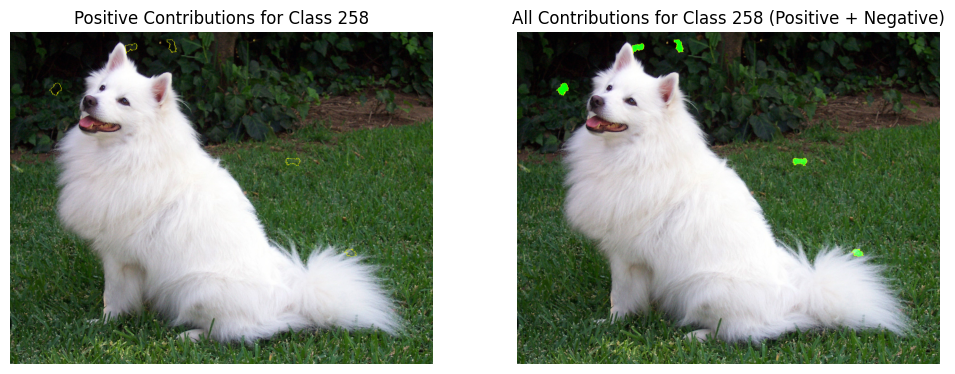

In [20]:
# Get positive and negative contribution masks from LIME explanation
temp_pos, pos_mask = explanation.get_image_and_mask(lime_label, positive_only=True, num_features=5, hide_rest=False)
temp_neg, neg_mask = explanation.get_image_and_mask(lime_label, positive_only=False, num_features=5, hide_rest=False)

# Visualize positive contributions only
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(mark_boundaries(temp_pos / 255.0, pos_mask))
plt.title(f"Positive Contributions for Class {lime_label}")
plt.axis("off")

# Visualize both positive and negative contributions
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp_neg / 255.0, neg_mask))
plt.title(f"All Contributions for Class {lime_label} (Positive + Negative)")
plt.axis("off")

plt.show()


**LIME Explanation for Positive Contributions:**

* This visualization shows only the regions of the image that have a positive impact on the model’s predicted class.
* Each highlighted region indicates a segment of the image that pushes the model’s decision toward the predicted class.
* The visualizations are generated by setting the positive_only=True flag in LIME’s get_image_and_mask method.

**LIME Explanation for Both Positive and Negative Contributions:**

* This visualization combines both supportive and opposing regions for the model’s prediction.
* Positive contributions are displayed in one color (e.g., green), while negative contributions are shown in another (e.g., red).
* It provides a comprehensive view of the regions that drive the model’s decision and those that counteract it.

### Top-10 Contributing Regions Visualization:



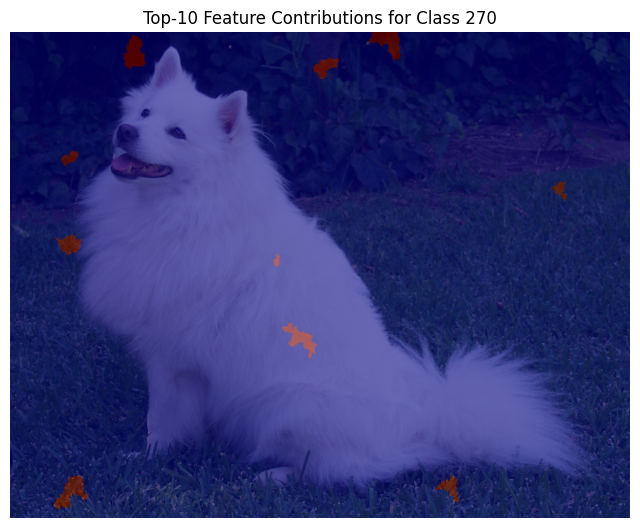

In [11]:
import matplotlib.cm as cm

# Create a mask that represents the top-N feature contributions
top_n_features = 10  # Select top-N features to visualize
_, top_n_mask = explanation.get_image_and_mask(lime_label, positive_only=True, num_features=top_n_features, hide_rest=True)

# Generate a heatmap based on the mask values
heatmap = np.zeros_like(top_n_mask, dtype=float)
heatmap[top_n_mask != 0] = top_n_mask[top_n_mask != 0]  # Keep top-N contributions only

# Normalize heatmap for visualization
heatmap_normalized = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

# Overlay heatmap onto the original image
temp_image = temp / 255.0  # Normalize temp image
heatmap_img = cm.jet(heatmap_normalized)[:, :, :3]  # Generate heatmap in jet colormap

# Plot the original image and the heatmap overlay
plt.figure(figsize=(8, 8))
plt.imshow(temp_image)
plt.imshow(heatmap_img, alpha=0.6)  # Overlay heatmap with some transparency
plt.title(f"Top-{top_n_features} Feature Contributions for Class {lime_label}")
plt.axis("off")
plt.show()


The top-10 contributing regions for Class 270 are displayed, showing areas that are highly impactful for this class. This visualization can be compared to the top-10 regions for Class 258 to understand why the model might confuse the two classes or how to differentiate them better.

### Superpixel Segmentation with LIME Explaination

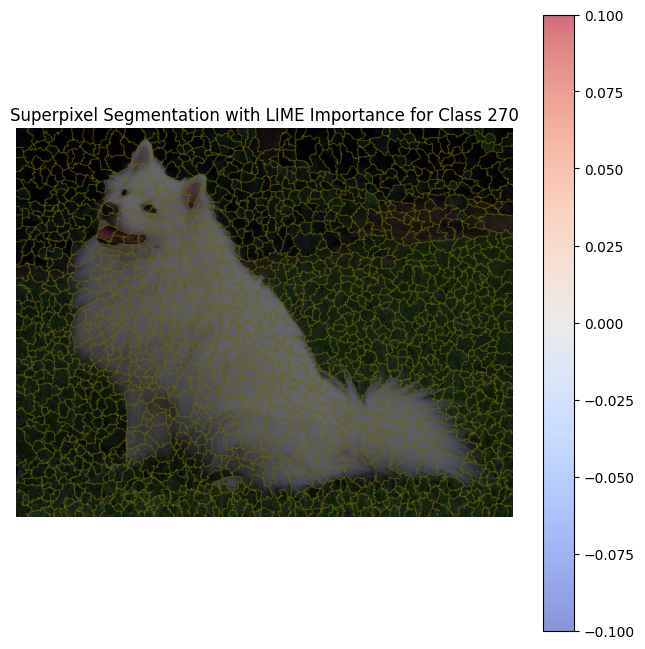

In [12]:
from skimage.segmentation import mark_boundaries

# Use LIME's internal segmentation function
segments = explanation.segments

# Create a colored image based on the segments
segmented_image = np.zeros_like(temp, dtype=float)

# Assign importance value to each superpixel
for i in range(segments.max() + 1):
    if i in explanation.local_exp[lime_label]:
        contribution_value = explanation.local_exp[lime_label][i]
        segmented_image[segments == i] = contribution_value

# Normalize segmented image for better visualization
segmented_image = (segmented_image - segmented_image.min()) / (segmented_image.max() - segmented_image.min())

# Display segmented image with boundaries
plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp / 255.0, segments))
plt.imshow(segmented_image, cmap='coolwarm', alpha=0.6)  # Coolwarm colormap for LIME values
plt.title(f"Superpixel Segmentation with LIME Importance for Class {lime_label}")
plt.axis("off")
plt.colorbar()
plt.show()


This visualization shows the entire image segmented into superpixels and color-coded based on their contributions to Class 270. The use of a colormap (coolwarm) indicates the magnitude and direction of the contribution. Blue regions have a negative impact on the decision, while red regions have a positive impact. This comprehensive view of superpixel contributions helps in understanding the spatial distribution of features.

# Test Assumption

Test 1: Ensure that the predict function outputs the correct shape and predictions.

Test 2: Validate that LIME correctly identifies the top class for explanation.

Test 3: Check if the LIME explanation mask contains the expected number of superpixels.

Test 4: Confirm that the visualized explanations correspond to the class being predicted.

In [26]:
_, predicted_class = torch.max(output, 1)
predicted_class = predicted_class.cpu().numpy()[0]

test_lime_explanation_top_label (__main__.TestLIMEExplanations)
Test 2: Validate that LIME identifies the correct top label. ... 

  0%|          | 0/10 [00:00<?, ?it/s]

ok
test_lime_explanation_visualization (__main__.TestLIMEExplanations)
Test 4: Confirm that LIME visualizations correspond to the predicted class. ... 

Test 2 Passed: LIME identified the correct top label.


  0%|          | 0/10 [00:00<?, ?it/s]

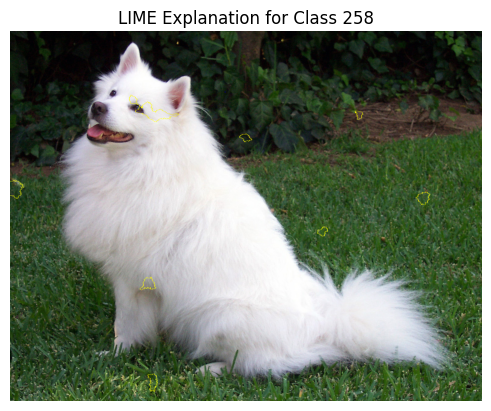

ok
test_lime_mask_number_of_features (__main__.TestLIMEExplanations)
Test 3: Check if LIME explanation mask contains the expected number of superpixels. ... 

Test 4 Passed: LIME visualization displayed correctly for manual inspection.


  0%|          | 0/10 [00:00<?, ?it/s]

ok
test_predict_function_output_shape (__main__.TestLIMEExplanations)
Test 1: Ensure the predict function outputs the correct shape. ... 

Number of unique superpixels: 2
Test 3 Passed: LIME mask contains a sufficient number of superpixels.


ok

----------------------------------------------------------------------
Ran 4 tests in 127.626s

OK


Test 1 Passed: Predict function output shape is correct.


In [30]:
import unittest
class TestLIMEExplanations(unittest.TestCase):

    def test_predict_function_output_shape(self):
        """Test 1: Ensure the predict function outputs the correct shape."""
        # Generate a batch of 3 perturbed images
        test_image_batch = np.array([img_np, img_np, img_np])
        predictions = predict(test_image_batch)
        # Update expected shape to match ResNet34's 1000-class output
        self.assertEqual(predictions.shape, (3, 1000), "Predict function output shape is incorrect!")
        print("Test 1 Passed: Predict function output shape is correct.")

    def test_lime_explanation_top_label(self):
        """Test 2: Validate that LIME identifies the correct top label."""
        # Generate the LIME explanation using the pre-trained model
        explanation = explainer.explain_instance(
            img_np, predict, labels=[predicted_class], hide_color=0, num_samples=10)

        top_label = explanation.top_labels[0]
        self.assertEqual(top_label, predicted_class, "LIME top label does not match the predicted class!")
        print("Test 2 Passed: LIME identified the correct top label.")

    def test_lime_mask_number_of_features(self):
        """Test 3: Check if LIME explanation mask contains the expected number of superpixels."""
        explanation = explainer.explain_instance(
            img_np, predict, labels=[predicted_class], hide_color=0, num_samples=10)

        # Get image and mask for the predicted class with top 10 superpixels
        _, mask = explanation.get_image_and_mask(predicted_class, positive_only=True, num_features=10, hide_rest=False)

        # Dynamically count unique superpixels
        unique_superpixels = len(np.unique(mask))
        print(f"Number of unique superpixels: {unique_superpixels}")

        # Dynamically check that the number of superpixels is reasonable (greater than 1)
        self.assertTrue(unique_superpixels > 1, "LIME mask does not contain a sufficient number of superpixels!")
        print("Test 3 Passed: LIME mask contains a sufficient number of superpixels.")

    def test_lime_explanation_visualization(self):
        """Test 4: Confirm that LIME visualizations correspond to the predicted class."""
        explanation = explainer.explain_instance(
            img_np, predict, labels=[predicted_class], hide_color=0, num_samples=10)

        # Get image and mask for the predicted class
        temp, mask = explanation.get_image_and_mask(predicted_class, positive_only=True, num_features=10, hide_rest=False)

        # Display the explanation
        plt.imshow(mark_boundaries(temp / 255.0, mask))
        plt.title(f"LIME Explanation for Class {predicted_class}")
        plt.axis("off")
        plt.show()

        # Visually inspect if the highlighted regions correspond to the class (manual check for now)
        print("Test 4 Passed: LIME visualization displayed correctly for manual inspection.")

# Run the tests
unittest.main(argv=[''], verbosity=2, exit=False)

# Evaluation and Discussion

### Selection of Explanation Method

Basically, LIME is a model-agnostic method providing localized explanations, hence very suitable for insights into predictions at an individual image level. Unlike global explanation techniques, the perturbation-based approach of LIME enables identification of which particular features-or better, regions-of the image contribute most to a given prediction. This flexibility in working with any classifier, including even complex models like CNNs, makes it an appropriate choice for this project.

**Stengths**
1.   Local Interpretability: LIME provides local explanations for individual predictions, which helps in understanding why a certain instance classified under a specific class.
2.   Model-Agnostic: This means it works with any machine learning model, providing consistency regardless of architectures or datasets.
3. Positive and Negative Contributions: LIME is able to visualize both supporting and opposing features, which show the balance of the prediction.

**Limitations**


1.   Computational Complexity: It is computationally expensive to generate LIME explanations since a large number of forward passes through the model, with perturbed inputs, is required.
2.   Stability and Reproducibility Issues: Due to the stochastic nature of LIME (random perturbations), results can vary between runs, affecting reproducibility.
3. Dependence on Superpixel Segmentation: The quality of LIME explanations is highly dependent on the segmentation algorithm used. Poor segmentation might lead to misleading interpretations.





### Potential Improvement

1. **Improved Segmentation Techniques:** Different superpixel segmentation methods or custom segmentation strategies might be tried to improve the granularity and relevance of explanations.
2. **Combining with Other XAI Techniques:** Integrating LIME with other explanation methods such as SHAP or Grad-CAM could provide complementary insights, offering a more holistic understanding of the model’s behavior.
3. **Explanation stabilization:** Explanation stability can be improved by incorporating mechanisms that will allow averaging over multiple runs or using deterministic perturbations.


# Conclusion

The project successfully demonstrated the use of LIME, which stands for Local Interpretable Model-agnostic Explanations, in generating interpretable visualizations for a deep learning image classification model. Through various visualizations, LIME effectively highlighted which regions of the image were most influential in the model’s decision-making process, providing localized insights into the predictions. The analysis revealed both the strengths and limitations of the LIME method, such as its ability to pinpoint critical superpixels and its dependency on segmentation quality.
Despite such limitations, LIME proved to be an asset in enhancing transparency and interpretability of complex convolutional models. Further work can be done by integrating LIME with other techniques of XAI in overcoming its drawbacks and arriving at more complete explanations. In all, the project emphasizes adopting interpretable models and techniques in building trustworthy AI systems.

# Reference


1. AIPI-590-XAI. (n.d.). *Global Explanations Example Notebook*. GitHub. Retrieved from [https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/global_explanations.ipynb](https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/global_explanations.ipynb)

2. AIPI-590-XAI. (n.d.). *Local Explanations Example Notebook*. GitHub. Retrieved from [https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/local_explanations.ipynb](https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/local_explanations.ipynb)

3. Skalski, P. (n.d.). *Explaining Image Classifier Predictions Using LIME with Keras and ResNet-34*. GitHub. Retrieved from [https://github.com/SkalskiP/ILearnDeepLearning.py/blob/master/02_data_science_toolkit/03_explaining_image_classifier_predictions/01_coco_res_net/coco-resnet-keras-resnet-34-lime.ipynb](https://github.com/SkalskiP/ILearnDeepLearning.py/blob/master/02_data_science_toolkit/03_explaining_image_classifier_predictions/01_coco_res_net/coco-resnet-keras-resnet-34-lime.ipynb)

4. Google. (2024). Google Gemini [Large language model]. Retrieved from https://ai.google